In [2]:
import pandas as pd
import polars as pl
import numpy as np
from openai import OpenAI
from tqdm import tqdm
import re

In [5]:
# df = pd.read_parquet("/data/gbg141/Arlequin/data/Arlequin_twitter_MAGA.parquet")
df = pd.read_csv("/data/gbg141/Arlequin/data/Arlequin_twitter_MAGA.csv")
df

,Unnamed: 0,id,content,parent,no. of comments,no. of likes,no. of shares,no. of views,post subtype,language,date,username,bio,no. of followers,no. of follows,reply_or_retweet
0,0,0_150937_8_1959768220274929930,"23. endless paranoid lunacy, now we have the c...",0_150937_8_1959766335837077582,0,1,1,1103,reply,en,2025-08-25,austerewyatt12,Scientist \ Based Inventor \ Nuclear Physisist...,165500,403,NaN
1,1,0_150937_8_1959768262759288951,@GavinNewsom You've gerrymandered 43 out of 52...,0_150937_8_1959398661814903014,0,27,6,1056,reply,en,2025-08-25,MAGAResource,MAGA News 24/7. Click 🔔+ Notify Above To Get B...,216682,980,GavinNewsom
2,2,0_150937_8_1959768489360826693,@GuntherEagleman Feels so good to be back. Ame...,0_150937_8_1959767375374319995,0,100,12,3374,reply,en,2025-08-25,MAGAVoice,Want to take back OUR country? JOIN ME 🇺🇸 Dona...,1291901,518,GuntherEagleman
3,3,0_150937_8_1959768526048444825,@MAGAPosts I absolutely did,0_150937_8_1959767202569089500,0,28,2,1393,reply,en,2025-08-25,MAGAVoice,Want to take back OUR country? JOIN ME 🇺🇸 Dona...,1291901,518,MAGAPosts
4,4,0_150937_8_1959768821293613507,JAG Corps ACTIVATE! https://t.co/673nVG0hWO,0,0,36,5,1152,quote,en,2025-08-25,paintsaints,All American Girl / Child of God / Believer / ...,36824,5315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39074,39074,0_150937_8_1967556303355846705,More on Charlie Kirk's legacyhttps://t.co/z8rB...,0,0,225,40,30820,original post,en,2025-09-15,marklevinshow,THIS IS THE OFFICIAL MARK LEVIN SHOW X PAGE. \...,4907838,5,NaN
39075,39075,0_150937_8_1967556408964186255,GM fam! How's everyone this morning? https://t...,0,0,203,32,9530,original post,en,2025-09-15,MJTruthUltra,"Watchdog, Researcher, Humor Specialist Unshaka...",563666,2777,NaN
39076,39076,0_150937_8_1967556713462264074,@TalkWithSally Not sure what you mean by movin...,0_150937_8_1967499428325163012,0,3,0,559,reply,en,2025-09-15,MJTruthUltra,"Watchdog, Researcher, Humor Specialist Unshaka...",563666,2777,TalkWithSally
39077,39077,0_150937_8_1967558427061997719,The Islamists on Charlie's assassinationhttps:...,0,0,209,67,30035,original post,en,2025-09-15,marklevinshow,THIS IS THE OFFICIAL MARK LEVIN SHOW X PAGE. \...,4907838,5,NaN


In [12]:
# generate integer message ids (and dict wrt original ids)
id_map = {elem: id for elem, id in zip(df["id"],pd.RangeIndex(len(df)))}
df["id"] = pd.RangeIndex(len(df))
df["parent_id"] = df["parent"].apply(lambda x: id_map.get(x, None))


In [26]:
# generate integer user ids
user_mapping = {user: idx for idx, user in enumerate(df['username'].unique())}
df['user_id'] = df['username'].map(user_mapping)

In [116]:
# generate integer time stamps
df["datestamp"] = df["date"].apply(lambda x: x.toordinal())

In [114]:
df["date"].iloc[15000].toordinal()

739497

In [ ]:
# generate reply_to_user_id
# only include users that exist in the dataset
df['reply_to_user_id'] = df['reply_or_retweet'].apply(
    lambda x: [user_mapping[username] for username in (x if isinstance(x, list) else [x] if x is not None else []) if username in user_mapping]
)

In [81]:
# generate mentions_user_id
# only include users that exist in the dataset
def extract_mentions(content):
    """Extract @username mentions from content."""
    if pd.isna(content):
        return []
    # Find all @username patterns
    mentions = re.findall(r'@(\w+)', str(content))
    # Filter to only include users in user_mapping
    return [user_mapping[username] for username in mentions if username in user_mapping]

df['mentions_user_id'] = df['content'].apply(extract_mentions)

In [ ]:
# get message embeddings
# get messages
msgs = np.array(df['content'])

# create an OpenAI client with your deepinfra token and endpoint
client = OpenAI(
    api_key="7jIPsm1yv398SZpzLaE0qw2DIs2Y5CZG",
    base_url="https://api.deepinfra.com/v1/openai",
)

# create batches
batch_size = 512
batches = [msgs[i:i + batch_size] for i in range(0, len(msgs), batch_size)]

# embed
embeddings = []
for i, batch in enumerate(tqdm(batches, desc="Embedding batches")):
    embedding = client.embeddings.create(
        model='BAAI/bge-m3',
        input = batch.tolist(),
        dimensions=1024,
        encoding_format='float',
    )
    embeddings.extend([x.embedding for x in embedding.data])

# save
df['embedding'] = embeddings

Embedding batches: 100%|██████████| 77/77 [06:00<00:00,  4.68s/it]


In [ ]:
# get bio embeddings
bios = np.array(df['bio'].replace({None: ""}))

# create batches
batch_size = 512
batches = [bios[i:i + batch_size] for i in range(0, len(bios), batch_size)]

# embed
embeddings = []
for i, batch in enumerate(tqdm(batches, desc="Embedding batches")):
    embedding = client.embeddings.create(
        model='BAAI/bge-m3',
        input=batch.tolist(),
        dimensions=1024,
        encoding_format='float',
    )
    embeddings.extend([x.embedding for x in embedding.data])

# save
df['bio_embedding'] = embeddings

Embedding batches: 100%|██████████| 77/77 [05:01<00:00,  3.91s/it]


In [38]:
# save
df_loaded.to_parquet("/data/gbg141/Arlequin/data/MAGA_embedded.parquet", index=False)

In [3]:
df_loaded = pd.read_parquet("/data/gbg141/Arlequin/data/MAGA_embedded.parquet")
df_loaded

,id,content,no. of comments,no. of likes,no. of shares,no. of views,post subtype,language,date,username,...,no. of followers,no. of follows,reply_or_retweet,user_id,reply_to_user_id,mentions_user_id,embedding,bio_embedding,datestamp,parent_id
0,0,"23. endless paranoid lunacy, now we have the c...",0,1,1,1103,reply,en,2025-08-25,austerewyatt12,...,165500,403,None,0,[],[],"[-0.018080048263072968, 0.029990049079060555, ...","[-0.002727521350607276, -0.003640637034550309,...",739488,NaN
1,1,@GavinNewsom You've gerrymandered 43 out of 52...,0,27,6,1056,reply,en,2025-08-25,MAGAResource,...,216682,980,GavinNewsom,1,[],[],"[-0.03978833556175232, -0.01148630678653717, 0...","[-0.01618366502225399, -0.007729790173470974, ...",739488,NaN
2,2,@GuntherEagleman Feels so good to be back. Ame...,0,100,12,3374,reply,en,2025-08-25,MAGAVoice,...,1291901,518,GuntherEagleman,2,[],[],"[-0.015221292153000832, 0.004700069781392813, ...","[-0.021167198196053505, 0.004752574488520622, ...",739488,NaN
3,3,@MAGAPosts I absolutely did,0,28,2,1393,reply,en,2025-08-25,MAGAVoice,...,1291901,518,MAGAPosts,2,[],[],"[0.012352042831480503, 0.0012695561163127422, ...","[-0.021167198196053505, 0.004752574488520622, ...",739488,NaN
4,4,JAG Corps ACTIVATE! https://t.co/673nVG0hWO,0,36,5,1152,quote,en,2025-08-25,paintsaints,...,36824,5315,None,3,[],[],"[-0.03979841619729996, -0.009771346114575863, ...","[-0.026603348553180695, -0.023830875754356384,...",739488,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39074,39074,More on Charlie Kirk's legacyhttps://t.co/z8rB...,0,225,40,30820,original post,en,2025-09-15,marklevinshow,...,4907838,5,None,10,[],[],"[-0.0430118702352047, 0.02245650812983513, -0....","[-0.03571410849690437, -0.05290907248854637, -...",739509,NaN
39075,39075,GM fam! How's everyone this morning? https://t...,0,203,32,9530,original post,en,2025-09-15,MJTruthUltra,...,563666,2777,None,19,[],[],"[-0.036922164261341095, -0.017795013263821602,...","[-0.04067656770348549, -0.0028596846386790276,...",739509,NaN
39076,39076,@TalkWithSally Not sure what you mean by movin...,0,3,0,559,reply,en,2025-09-15,MJTruthUltra,...,563666,2777,TalkWithSally,19,[],[],"[-0.027035817503929138, 0.03753622993826866, -...","[-0.04067656770348549, -0.0028596846386790276,...",739509,NaN
39077,39077,The Islamists on Charlie's assassinationhttps:...,0,209,67,30035,original post,en,2025-09-15,marklevinshow,...,4907838,5,None,10,[],[],"[0.009211130440235138, 0.028164757415652275, -...","[-0.03571410849690437, -0.05290907248854637, -...",739509,NaN


In [5]:
df_loaded.groupby('user_id').first()

,id,content,no. of comments,no. of likes,no. of shares,no. of views,post subtype,language,date,username,bio,no. of followers,no. of follows,reply_or_retweet,reply_to_user_id,mentions_user_id,embedding,bio_embedding,datestamp,parent_id
user_id,,,,,,,,,,,,,,,,,,,,
0,0,"23. endless paranoid lunacy, now we have the c...",0,1,1,1103,reply,en,2025-08-25,austerewyatt12,Scientist \ Based Inventor \ Nuclear Physisist...,165500,403,None,[],[],"[-0.018080048263072968, 0.029990049079060555, ...","[-0.002727521350607276, -0.003640637034550309,...",739488,0.0
1,1,@GavinNewsom You've gerrymandered 43 out of 52...,0,27,6,1056,reply,en,2025-08-25,MAGAResource,MAGA News 24/7. Click 🔔+ Notify Above To Get B...,216682,980,GavinNewsom,[],[],"[-0.03978833556175232, -0.01148630678653717, 0...","[-0.01618366502225399, -0.007729790173470974, ...",739488,547.0
2,2,@GuntherEagleman Feels so good to be back. Ame...,0,100,12,3374,reply,en,2025-08-25,MAGAVoice,Want to take back OUR country? JOIN ME 🇺🇸 Dona...,1291901,518,GuntherEagleman,[],[],"[-0.015221292153000832, 0.004700069781392813, ...","[-0.021167198196053505, 0.004752574488520622, ...",739488,219.0
3,4,JAG Corps ACTIVATE! https://t.co/673nVG0hWO,0,36,5,1152,quote,en,2025-08-25,paintsaints,All American Girl / Child of God / Believer / ...,36824,5315,JoeyMannarinoUS,[],[],"[-0.03979841619729996, -0.009771346114575863, ...","[-0.026603348553180695, -0.023830875754356384,...",739488,1518.0
4,9,RT @Hunter_Eagleman: I didn't realize all of @...,0,0,0,0,repost,en,2025-08-25,magaforce24,🏆Trump Won🏆America 1st🇺🇸Close Border🪟Military🔥...,9745,6934,Hunter_Eagleman,[],[],"[-0.05433293431997299, -0.026081502437591553, ...","[0.03466068208217621, -0.00013315385149326175,...",739488,1979.0
5,22,LOVE THIS… https://t.co/WkQq7r0sES,0,38,10,1419,quote,en,2025-08-25,SirCensorLot,"NYC IRONWORKER 9/11 FIRST RESPONDER/SURVIVOR, ...",48954,1798,qaggnews,[],[],"[-0.017307396978139877, 0.04071759060025215, -...","[-0.010940480045974255, 0.019301559776067734, ...",739488,731.0
6,29,RT @ShidelerK: So after several years of tryin...,0,0,0,0,repost,en,2025-08-25,davereaboi,"National security, media & political warfare. ...",199492,3977,Hammerjack90,[],[],"[-0.03399119898676872, 0.011556560173630714, 0...","[-0.0733732059597969, 0.013070981949567795, -0...",739488,909.0
7,40,RT @RadioFaceAz: Baiting someone into saying f...,0,0,0,0,repost,en,2025-08-25,SpunkyPatriot_,"Unfiltered, America First, ♀Catholic, GenX, Se...",67886,9637,DahenchX,[],[],"[-0.0016347531927749515, 0.03280973434448242, ...","[-0.019785843789577484, -0.008510666899383068,...",739488,1220.0
8,42,RT @StackerStellar: Long time coming and just ...,0,0,0,0,repost,en,2025-08-25,Twiztid_One_,#LulzBoyz 😎 #WWG1WGA 🇺🇸 #DigitalSoldier ⚔️ #S...,9584,1242,boonecutler,[],[],"[0.0054952967911958694, -0.002890713280066848,...","[-0.037016306072473526, 0.027884967625141144, ...",739488,610.0


In [3]:
# Create dictionary mapping user_id to bio_embedding
# Since same user may appear in multiple rows, take first occurrence of each user
user_bio_dict = df_loaded.groupby('user_id').first()['bio_embedding'].to_dict()

print(f"Number of unique users: {len(user_bio_dict)}")
print(f"Sample entry - User ID {list(user_bio_dict.keys())[0]}: embedding length = {len(list(user_bio_dict.values())[0])}")
user_bio_dict

Number of unique users: 39
Sample entry - User ID 0: embedding length = 1024


{0: array([-0.00272752, -0.00364064, -0.02725048, ...,  0.02474519,
        -0.01576606, -0.034105  ], shape=(1024,)),
 1: array([-0.01618367, -0.00772979,  0.00272172, ...,  0.02084414,
        -0.05028064, -0.0043202 ], shape=(1024,)),
 2: array([-0.0211672 ,  0.00475257, -0.01011135, ..., -0.00311365,
        -0.04229481, -0.02219048], shape=(1024,)),
 3: array([-0.02660335, -0.02383088, -0.05659523, ...,  0.04882511,
        -0.03916373, -0.00329688], shape=(1024,)),
 4: array([ 0.03466068, -0.00013315, -0.0304797 , ..., -0.03679021,
        -0.04252641, -0.02298679], shape=(1024,)),
 5: array([-0.01094048,  0.01930156, -0.04858491, ..., -0.01778071,
         0.05762662,  0.02081432], shape=(1024,)),
 6: array([-0.07337321,  0.01307098, -0.00878628, ..., -0.00784972,
         0.00213515,  0.0137512 ], shape=(1024,)),
 7: array([-0.01978584, -0.00851067, -0.00061903, ...,  0.02616262,
        -0.03806692, -0.00856183], shape=(1024,)),
 8: array([-0.03701631,  0.02788497,  0.00147987

In [6]:
# Remove NaN/None values from unique parent_ids
unique_parents = np.unique(df_loaded['parent_id'])
unique_parents = unique_parents[~pd.isna(unique_parents)]
unique_parents

array([0.0000e+00, 6.0000e+00, 1.6000e+01, ..., 3.9035e+04, 3.9048e+04,
       3.9049e+04], shape=(1493,))

In [7]:
613 in unique_parents

False

In [8]:
df_loaded["parent_id"][14:20]

14    NaN
15    NaN
16    6.0
17    NaN
18    NaN
19    NaN
Name: parent_id, dtype: float64

In [9]:
# Group by parent_id and find entries with common parent
grouped = df_loaded.groupby('parent_id').size()
# Filter to only show parent_ids that have multiple children (2 or more)
common_parents = grouped[grouped > 1].sort_values(ascending=False)
print(f"Number of parent_ids with multiple children: {len(common_parents)}")
print(f"\nTop 10 parent_ids with most children:")
print(common_parents.head(10))

# To see all entries for a specific parent_id, use:
# df_loaded[df_loaded['parent_id'] == some_parent_id]

Number of parent_ids with multiple children: 183

Top 10 parent_ids with most children:
parent_id
1188.0    5
9980.0    5
6437.0    5
6336.0    4
7049.0    4
4390.0    4
7991.0    4
7413.0    4
8722.0    4
8021.0    4
dtype: int64


In [10]:
id_map["0_150937_8_1959768220274929930"]

NameError: name 'id_map' is not defined

In [11]:
# Create hyperedges: each hyperedge contains the root post and ALL descendants in the thread
# First, trace each message back to its root ancestor
def find_root_ancestor(msg_id, parent_dict):
    """Trace back to find the root ancestor of a message."""
    visited = set()
    current = msg_id
    
    while current in parent_dict and pd.notna(parent_dict[current]):
        if current in visited:  # Avoid infinite loops
            break
        visited.add(current)
        current = int(parent_dict[current])
    
    return current

# Create a mapping of message_id -> parent_id for faster lookup
parent_dict = df_loaded.set_index('id')['parent_id'].to_dict()

# Find the root ancestor for each message
df_loaded['root_ancestor'] = df_loaded['id'].apply(lambda x: find_root_ancestor(x, parent_dict))

# Group all messages by their root ancestor (original post)
hyperedges = []
for root_id, group in df_loaded.groupby('root_ancestor'):
    # Create hyperedge: [root_id, descendant1_id, descendant2_id, ...]
    all_ids = group['id'].tolist()
    
    # Only include if there are replies (hyperedge size > 1)
    if len(all_ids) > 1:
        # Ensure root is first in the list
        if root_id in all_ids:
            all_ids.remove(root_id)
        hyperedge = [int(root_id)] + all_ids
        hyperedges.append(hyperedge)

print(f"Total number of conversation threads (hyperedges): {len(hyperedges)}")
print(f"\nFirst 5 hyperedges (root + all descendants):")
for i, edge in enumerate(hyperedges[:5]):
    print(f"Hyperedge {i+1}: Root={edge[0]}, Descendants={edge[1:]} (total size={len(edge)})")

Total number of conversation threads (hyperedges): 886

First 5 hyperedges (root + all descendants):
Hyperedge 1: Root=0, Descendants=[6, 16, 20, 24, 27, 32, 35, 39, 45, 47, 49, 53, 56, 58, 63, 78, 82, 86, 94, 110, 118, 125] (total size=23)
Hyperedge 2: Root=30, Descendants=[950] (total size=2)
Hyperedge 3: Root=119, Descendants=[480] (total size=2)
Hyperedge 4: Root=175, Descendants=[22113] (total size=2)
Hyperedge 5: Root=182, Descendants=[4101] (total size=2)


In [12]:
hyperedges

[[0,
  6,
  16,
  20,
  24,
  27,
  32,
  35,
  39,
  45,
  47,
  49,
  53,
  56,
  58,
  63,
  78,
  82,
  86,
  94,
  110,
  118,
  125],
 [30, 950],
 [119, 480],
 [175, 22113],
 [182, 4101],
 [187, 4100],
 [207, 4099],
 [219, 224],
 [225, 226],
 [463, 466],
 [535, 543],
 [547, 604],
 [581, 788],
 [610, 613, 688, 1299],
 [617, 4098],
 [638, 828],
 [731,
  732,
  733,
  734,
  735,
  736,
  737,
  738,
  739,
  740,
  741,
  742,
  743,
  744,
  745,
  746,
  747,
  748,
  749],
 [789, 1107],
 [843, 860],
 [856, 2066],
 [872, 873, 875, 1047],
 [889, 894],
 [909, 914],
 [920, 1528],
 [1041, 4097],
 [1059,
  1083,
  1095,
  1103,
  1112,
  1115,
  1122,
  1126,
  1136,
  1146,
  1149,
  1156,
  1170,
  1182,
  1191,
  1199,
  1205,
  1210,
  1217,
  1231,
  1236],
 [1188, 1192, 1319, 1362, 1363, 1378],
 [1190, 4096],
 [1220, 1672],
 [1439, 1441],
 [1518, 1519],
 [1533, 11817],
 [1534, 11815],
 [1540, 5767],
 [1554, 4094],
 [1559, 4093],
 [1563, 11813],
 [1568, 4767],
 [1572, 3139],
 [16

In [13]:
# Check the distribution of replies vs reposts in the data
# Check the "post_subtype" column

if 'post subtype' in df_loaded.columns:
    print("Post subtype distribution:")
    print(df_loaded['post subtype'].value_counts())
    print(f"\nTotal messages: {len(df_loaded)}")
    
    # Check how many of each type have parent_id
    print("\n" + "="*60)
    print("Parent_id status by post_subtype:")
    for subtype in df_loaded['post subtype'].unique():
        if pd.notna(subtype):
            subtype_data = df_loaded[df_loaded['post subtype'] == subtype]
            has_parent = subtype_data['parent_id'].notna().sum()
            no_parent = subtype_data['parent_id'].isna().sum()
            print(f"  {subtype}: {has_parent} have parent_id, {no_parent} don't")
    
    print("\n" + "="*60)
    print("HYPEREDGE INCLUSION:")
    print("✓ Messages with parent_id ARE included in conversation threads")
    print("✗ Messages without parent_id are NOT linked to any thread")
    print("\nIf reposts don't have parent_id set, they won't be in hyperedges!")
    print("="*60)
else:
    print("Column 'post_subtype' not found in df_loaded")
    print("Available columns:", df_loaded.columns.tolist())

Post subtype distribution:
post subtype
repost           26256
reply             5712
original post     4145
quote             2966
Name: count, dtype: int64

Total messages: 39079

Parent_id status by post_subtype:
  reply: 949 have parent_id, 4763 don't
  quote: 0 have parent_id, 2966 don't
  repost: 812 have parent_id, 25444 don't
  original post: 0 have parent_id, 4145 don't

HYPEREDGE INCLUSION:
✓ Messages with parent_id ARE included in conversation threads
✗ Messages without parent_id are NOT linked to any thread

If reposts don't have parent_id set, they won't be in hyperedges!


In [14]:
# Check if hyperedges contain BOTH replies AND reposts (not counting original posts)
if 'post subtype' in df_loaded.columns:
    reply_repost_hyperedges = []
    
    for edge in hyperedges:
        # Get post subtypes for all messages in this hyperedge
        edge_data = df_loaded[df_loaded['id'].isin(edge)]
        subtypes = edge_data['post subtype'].tolist()
        
        # Check if this hyperedge has BOTH reply and repost
        has_reply = any('reply' in str(s).lower() for s in subtypes if pd.notna(s))
        has_repost = any('repost' in str(s).lower() for s in subtypes if pd.notna(s))
        
        if has_reply and has_repost:
            unique_subtypes = edge_data['post subtype'].value_counts().to_dict()
            reply_repost_hyperedges.append({
                'edge': edge,
                'subtype_counts': unique_subtypes,
                'size': len(edge)
            })
    
    print(f"Total hyperedges: {len(hyperedges)}")
    print(f"Hyperedges containing BOTH replies AND reposts: {len(reply_repost_hyperedges)}")
    print(f"Percentage: {100 * len(reply_repost_hyperedges) / len(hyperedges):.2f}%")
    
    if len(reply_repost_hyperedges) > 0:
        print(f"\n{'='*60}")
        print("First 5 examples of hyperedges with BOTH replies and reposts:")
        for i, example in enumerate(reply_repost_hyperedges[:5]):
            print(f"\nExample {i+1}:")
            print(f"  Total size: {example['size']} messages")
            print(f"  Breakdown by type: {example['subtype_counts']}")
            print(f"  Message IDs: {example['edge'][:10]}..." if len(example['edge']) > 10 else f"  Message IDs: {example['edge']}")
    else:
        print("\nNo hyperedges found with BOTH replies and reposts.")
        print("This might mean reposts don't have parent_id set, or they're tracked differently.")
else:
    print("Column 'post subtype' not found")

Total hyperedges: 886
Hyperedges containing BOTH replies AND reposts: 120
Percentage: 13.54%

First 5 examples of hyperedges with BOTH replies and reposts:

Example 1:
  Total size: 4 messages
  Breakdown by type: {'repost': 2, 'original post': 1, 'reply': 1}
  Message IDs: [610, 613, 688, 1299]

Example 2:
  Total size: 2 messages
  Breakdown by type: {'reply': 1, 'repost': 1}
  Message IDs: [856, 2066]

Example 3:
  Total size: 4 messages
  Breakdown by type: {'reply': 2, 'quote': 1, 'repost': 1}
  Message IDs: [872, 873, 875, 1047]

Example 4:
  Total size: 2 messages
  Breakdown by type: {'reply': 1, 'repost': 1}
  Message IDs: [1041, 4097]

Example 5:
  Total size: 6 messages
  Breakdown by type: {'reply': 4, 'original post': 1, 'repost': 1}
  Message IDs: [1188, 1192, 1319, 1362, 1363, 1378]


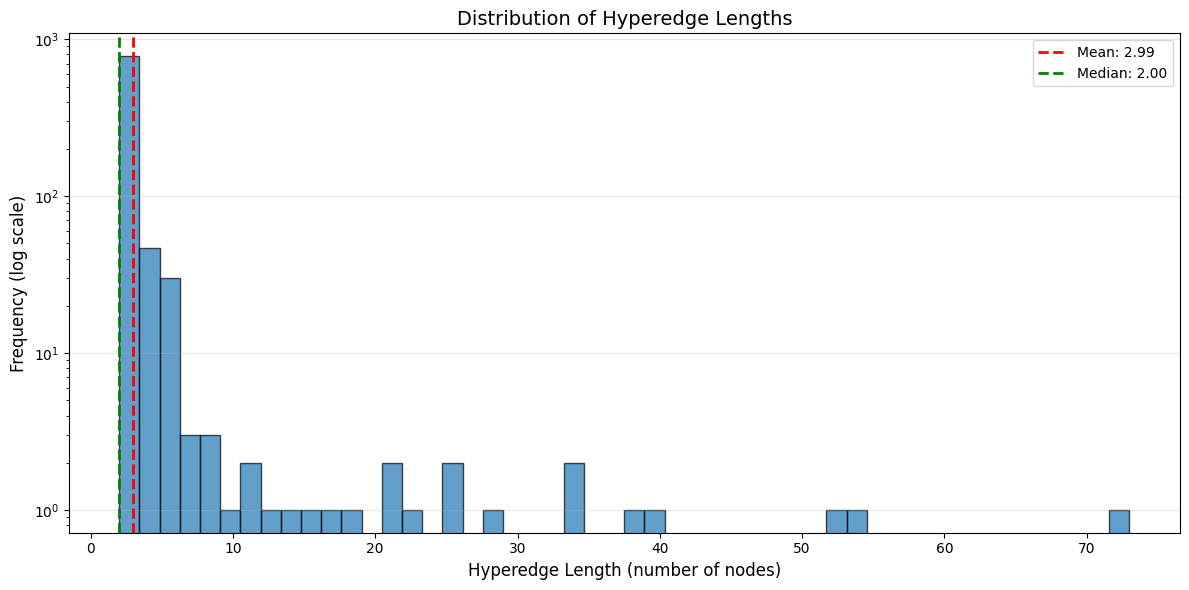


Hyperedge Length Statistics:
Mean: 2.99
Median: 2.00
Min: 2
Max: 73
Std Dev: 4.64


In [15]:
import matplotlib.pyplot as plt

# Calculate hyperedge lengths
hyperedge_lengths = [len(edge) for edge in hyperedges]

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(hyperedge_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Hyperedge Length (number of nodes)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.yscale('log')
plt.title('Distribution of Hyperedge Lengths', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add statistics to the plot
mean_length = np.mean(hyperedge_lengths)
median_length = np.median(hyperedge_lengths)
plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='--', linewidth=2, label=f'Median: {median_length:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nHyperedge Length Statistics:")
print(f"Mean: {mean_length:.2f}")
print(f"Median: {median_length:.2f}")
print(f"Min: {min(hyperedge_lengths)}")
print(f"Max: {max(hyperedge_lengths)}")
print(f"Std Dev: {np.std(hyperedge_lengths):.2f}")

In [21]:
# Flatten list of lists (hyperedges to get all unique node IDs)
# Method 1: List comprehension (most Pythonic)
flattened_nodes = [node_id for edge in hyperedges for node_id in edge]

print(f"Total nodes in flattened list: {len(flattened_nodes)}")
print(f"Unique nodes: {len(set(flattened_nodes))}")
print(f"First 20 nodes: {flattened_nodes[:20]}")

# Alternative methods:
# Method 2: Using itertools.chain
# from itertools import chain
# flattened_nodes = list(chain(*hyperedges))

# Method 3: Using sum (less efficient for large lists)
# flattened_nodes = sum(hyperedges, [])

Total nodes in flattened list: 3254
Unique nodes: 2647
First 20 nodes: [0, 6, 6, 16, 16, 20, 20, 24, 24, 27, 27, 32, 30, 950, 32, 35, 35, 39, 39, 45]


In [24]:
hyperedges

[[0, 6],
 [6, 16],
 [16, 20],
 [20, 24],
 [24, 27],
 [27, 32],
 [30, 950],
 [32, 35],
 [35, 39],
 [39, 45],
 [45, 47],
 [47, 49],
 [49, 53],
 [53, 56],
 [56, 58],
 [58, 63],
 [63, 78],
 [78, 82],
 [82, 86],
 [86, 94],
 [94, 110],
 [110, 118],
 [118, 125],
 [119, 480],
 [175, 22113],
 [182, 4101],
 [187, 4100],
 [207, 4099],
 [219, 224],
 [225, 226],
 [463, 466],
 [535, 543],
 [547, 604],
 [581, 788],
 [610, 613, 688, 1299],
 [617, 4098],
 [638, 828],
 [731, 732],
 [732, 733],
 [733, 734],
 [734, 735],
 [735, 736],
 [736, 737],
 [737, 738],
 [738, 739],
 [739, 740],
 [740, 741],
 [741, 742],
 [742, 743],
 [743, 744],
 [744, 745],
 [745, 746],
 [746, 747],
 [747, 748],
 [748, 749],
 [789, 1107],
 [843, 860],
 [856, 2066],
 [872, 873, 1047],
 [873, 875],
 [889, 894],
 [909, 914],
 [920, 1528],
 [1041, 4097],
 [1059, 1083],
 [1083, 1095],
 [1095, 1103],
 [1103, 1112],
 [1112, 1115],
 [1115, 1122],
 [1122, 1126],
 [1126, 1136],
 [1136, 1146],
 [1146, 1149],
 [1149, 1156],
 [1156, 1170],
 [1

In [37]:
df_loaded.iloc[1188]

id                                                               1188
content                                       https://t.co/piBX4Xnq2a
no. of comments                                                     0
no. of likes                                                       53
no. of shares                                                      44
no. of views                                                     3406
post subtype                                            original post
language                                                         None
date                                                       2025-08-26
username                                                 GolfingFrogs
bio                 #Spaceshost | #TRUMP2024| #FightLikeAFlynn| #W...
no. of followers                                                19038
no. of follows                                                   2022
reply_or_retweet                                                 None
user_id             

In [10]:
"0_150937_8_1959768220274929930" in list(np.unique(df["parent"]))

True

In [78]:
user_mapping

{'austerewyatt12': 0,
 'MAGAResource': 1,
 'MAGAVoice': 2,
 'paintsaints': 3,
 'magaforce24': 4,
 'SirCensorLot': 5,
 'davereaboi': 6,
 'SpunkyPatriot_': 7,
 'Twiztid_One_': 8,
 'LauraLoomer': 9,
 'marklevinshow': 10,
 'JackPosobiec': 11,
 'texan_maga': 12,
 'GolfingFrogs': 13,
 'charliekirk11': 14,
 'tedcruz': 15,
 'truth_ac': 16,
 'MattWalshBlog': 17,
 'THeinrich22': 18,
 'MJTruthUltra': 19,
 'JtShaggy': 20,
 'seanhannity': 21,
 'RepMTG': 22,
 'mtgreenee': 23,
 'TuckerCarlson': 24,
 'DC_Draino': 25,
 'LindseyGrahamSC': 26,
 'RealSeq16': 27,
 'JDVance': 28,
 'RealCandaceO': 29,
 'nancy_hamm1': 30,
 'Badged_Patriot': 31,
 'JamesOKeefeIII': 32,
 '1776Eagles': 33,
 'wwwMAGA_': 34,
 'laurenboebert': 35,
 'kayleighmcenany': 36,
 'TulsiGabbard': 37,
 'realDonaldTrump': 38}

In [74]:
df.iloc[39065]

id                                         15093781967551033623945685
content             RT @robertdunlap947: The media and talking hea...
no. of comments                                                     0
no. of likes                                                        0
no. of shares                                                       0
no. of views                                                        0
post subtype                                                   repost
language                                                           en
date                                                       2025-09-15
username                                                  THeinrich22
bio                 🎺 TRUMP💥MAGA, Nationalist, #Patriot, #Constitu...
no. of followers                                                70857
no. of follows                                                  53446
reply_or_retweet                                                 None
user_id             

In [6]:
df

,Unnamed: 0,id,content,parent,no. of comments,no. of likes,no. of shares,no. of views,post subtype,language,date,username,bio,no. of followers,no. of follows,reply_or_retweet
0,0,0_150937_8_1959768220274929930,"23. endless paranoid lunacy, now we have the c...",0_150937_8_1959766335837077582,0,1,1,1103,reply,en,2025-08-25,austerewyatt12,Scientist \ Based Inventor \ Nuclear Physisist...,165500,403,NaN
1,1,0_150937_8_1959768262759288951,@GavinNewsom You've gerrymandered 43 out of 52...,0_150937_8_1959398661814903014,0,27,6,1056,reply,en,2025-08-25,MAGAResource,MAGA News 24/7. Click 🔔+ Notify Above To Get B...,216682,980,GavinNewsom
2,2,0_150937_8_1959768489360826693,@GuntherEagleman Feels so good to be back. Ame...,0_150937_8_1959767375374319995,0,100,12,3374,reply,en,2025-08-25,MAGAVoice,Want to take back OUR country? JOIN ME 🇺🇸 Dona...,1291901,518,GuntherEagleman
3,3,0_150937_8_1959768526048444825,@MAGAPosts I absolutely did,0_150937_8_1959767202569089500,0,28,2,1393,reply,en,2025-08-25,MAGAVoice,Want to take back OUR country? JOIN ME 🇺🇸 Dona...,1291901,518,MAGAPosts
4,4,0_150937_8_1959768821293613507,JAG Corps ACTIVATE! https://t.co/673nVG0hWO,0,0,36,5,1152,quote,en,2025-08-25,paintsaints,All American Girl / Child of God / Believer / ...,36824,5315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39074,39074,0_150937_8_1967556303355846705,More on Charlie Kirk's legacyhttps://t.co/z8rB...,0,0,225,40,30820,original post,en,2025-09-15,marklevinshow,THIS IS THE OFFICIAL MARK LEVIN SHOW X PAGE. \...,4907838,5,NaN
39075,39075,0_150937_8_1967556408964186255,GM fam! How's everyone this morning? https://t...,0,0,203,32,9530,original post,en,2025-09-15,MJTruthUltra,"Watchdog, Researcher, Humor Specialist Unshaka...",563666,2777,NaN
39076,39076,0_150937_8_1967556713462264074,@TalkWithSally Not sure what you mean by movin...,0_150937_8_1967499428325163012,0,3,0,559,reply,en,2025-09-15,MJTruthUltra,"Watchdog, Researcher, Humor Specialist Unshaka...",563666,2777,TalkWithSally
39077,39077,0_150937_8_1967558427061997719,The Islamists on Charlie's assassinationhttps:...,0,0,209,67,30035,original post,en,2025-09-15,marklevinshow,THIS IS THE OFFICIAL MARK LEVIN SHOW X PAGE. \...,4907838,5,NaN


In [77]:
np.unique(df["reply_to_user_id"].replace({None: ""}))

array([list([]), list([1]), list([2]), list([3]), list([5]), list([8]),
       list([9]), list([10]), list([11]), list([13]), list([14]),
       list([15]), list([17]), list([19]), list([22]), list([25]),
       list([26]), list([28]), list([29]), list([30]), list([32]),
       list([37]), list([38])], dtype=object)

In [4]:
np.unique(df["reply_or_retweet"].replace({None: "None"}))

array(['01splcheck', '0HOUR1__', '0tt0rama', ..., 'zierbox', 'zk__nova',
       'zriboua'], shape=(2407,), dtype=object)

In [5]:
"GavinNewsom" in np.unique(df["reply_or_retweet"].replace({None: "None"}))

True

In [38]:
df['content'][39078]

'FBI Director Kash Patel confirms DNA match of Tyler Robinson with the towel used to wrap the rifle and a screwdriver found at the sniper nestATF is analyzing the rifle itself and will provide DNA results soonKash confirms dozens of people in Leftist group chats are being https://t.co/sxTx26b9Yc'

In [ ]:
# Remove URLs from the content column and replace by a tag
# df['content'].apply(lambda x: re.sub(r'http\S+|www\.\S+', ' [url link]', str(x)))[39074]

"More on Charlie Kirk's legacy [url link]"

In [ ]:
# Remove URLs and user mentions from content and replace by a tag
# df['content'].apply(lambda x: re.sub(r'@\w+', '[user mention]', str(x)))[3]

'[user mention] I absolutely did'

In [12]:
# get messages
msgs = np.array(df['content'])[:10000]

# create an OpenAI client with your deepinfra token and endpoint
client = OpenAI(
    api_key="7jIPsm1yv398SZpzLaE0qw2DIs2Y5CZG",
    base_url="https://api.deepinfra.com/v1/openai",
)

# create batches
batch_size = 512
batches = np.array_split(msgs, int(len(msgs) / batch_size))

# embed
embeddings = []
for i, batch in enumerate(batches):
    embedding = client.embeddings.create(
        model='BAAI/bge-m3',
        input = batch,
        dimensions=1024,
        encoding_format='float',
    )
    embeddings.extend([x.embedding for x in embedding.data])
    print('Batch ', i+1, ' Done')

# save
df['embedding'] = embeddings

Batch  1  Done
Batch  2  Done
Batch  3  Done
Batch  4  Done
Batch  5  Done
Batch  6  Done
Batch  7  Done
Batch  8  Done
Batch  9  Done
Batch  10  Done
Batch  11  Done
Batch  12  Done
Batch  13  Done
Batch  14  Done
Batch  15  Done
Batch  16  Done
Batch  17  Done
Batch  18  Done
Batch  19  Done


ValueError: Length of values (10000) does not match length of index (39079)

In [13]:
len(embeddings)

10000

In [31]:
# get messages
bios = np.array(df['bio'].replace({None: ""}))[:1000]

# create batches
batch_size = 512
batches = [bios[i:i + batch_size] for i in range(0, len(bios), batch_size)]

# embed
embeddings = []
for i, batch in enumerate(batches):
    embedding = client.embeddings.create(
        model='BAAI/bge-m3',
        input=batch.tolist(),
        dimensions=1024,
        encoding_format='float',
    )
    embeddings.extend([x.embedding for x in embedding.data])
    print('Batch ', i+1, ' Done')

# save
df['bio_embedding'] = embeddings

Batch  1  Done
Batch  2  Done


ValueError: Length of values (1000) does not match length of index (39079)

In [33]:
batches[1].shape

(488,)

In [24]:
np.unique(df["bio"].replace({None: ""})).shape

(39,)

In [41]:
twitter = pd.read_parquet("/data/gbg141/Arlequin/data/twitter_s10k.parquet")

In [122]:
twitter

,id,message,user_id,mentions_user_id,reply_to_user_id,embedding
0,1.885405e+18,"""@valerieboyer13 @leJDD Le JDD il ne manquait ...",1603103689585135616,"['276934698', '49678509']",['276934698'],"[-0.0011729525867849588, 0.03560536354780197, ..."
1,1.881385e+18,"""@AjaxVV8 En vervanger? jullie idee ik zou het...",54851208,['1134847436164349952'],['1134847436164349952'],"[-0.027059949934482574, -0.008414551615715027,..."
2,1.883763e+18,"""@Spidermandurct Notre équipe ""type"" montre be...",1348259857460326405,['1515443772338884616'],['1515443772338884616'],"[-0.06197907030582428, -0.0012791703920811415,..."
3,1.880636e+18,"""@christinblack_ Awwwnnnnn....Hot 🔥 my Sweet L...",2774381316,['1543888212149534720'],['1543888212149534720'],"[0.014438987709581852, 0.019704950973391533, -..."
4,1.880621e+18,"""@MiltysWorldX Ah!",1406516521380220930,['1259314706277416962'],['1259314706277416962'],"[-0.028360256925225258, -0.001895296503789723,..."
...,...,...,...,...,...,...
9995,1.883012e+18,"""@SavvyRinu Very very sad",882321415,['991043283534139392'],['991043283534139392'],"[-0.03760543838143349, 0.02799161709845066, -0..."
9996,1.881306e+18,"""@realTrumpNewsX https://t.co/arH1JchveU @SHAR...",1591005173068988416,['1810341133911994368'],['1810341133911994368'],"[-0.03130640462040901, -0.014854795299470425, ..."
9997,1.881112e+18,"""@MashiRafael https://t.co/5qafWV8XBM @SHARE E...",1318196918829391877,['209780362'],['209780362'],"[-0.016084255650639534, 0.020587023347616196, ..."
9998,1.885315e+18,"""@TMerk4343 @mjfree He's one of the most disgu...",48079936,"['1589295407632420865', '24113137']",['1589295407632420865'],"[-0.035898495465517044, 0.023607270792126656, ..."


In [40]:
pd.read_csv("/data/gbg141/Arlequin/data/twitter_dataset.csv")

,id,conversation_id,source,message,user_id,username,name,mentions_user_id,mentions_name,mentions_username,reply_to_user_id,reply_to_username,anger,joy,disgust,fear,neutral,sadness,surprise
0,1.885383e+18,1.885378e+18,twitter,"""@roberthabeck Lächerliches Statement \nDie Gr...",1393649084020428801,Marcel66036691,Marcel,['1852291228475289600'],['Robert Habeck'],['roberthabeck'],['1852291228475289600'],['roberthabeck'],0.01,0.00,0.01,0.01,0.00,0.97,0.00
1,1.885383e+18,1.885373e+18,twitter,"""@FabrizioRomano 😂😂😂 Spurs are a joke",3076467441,FredMarcel09,FredMarcel09,['330262748'],['Fabrizio Romano'],['FabrizioRomano'],['330262748'],['FabrizioRomano'],0.35,0.31,0.09,0.04,0.05,0.05,0.11
2,1.885380e+18,1.885359e+18,twitter,"""@Zebandrew Sorry ass game lmfao",1649577445903806464,marcelywelly,marcel 🥤,['1418928032937566218'],['drew😀'],['Zebandrew'],['1418928032937566218'],['Zebandrew'],0.14,0.19,0.06,0.15,0.04,0.38,0.04
3,1.885380e+18,1.885365e+18,twitter,"""@jensspahn Nein, die Bürgen wissen jetzt, das...",1825229241866141696,sofapolitik,Marcel Schneider,['299650387'],['Jens Spahn'],['jensspahn'],['299650387'],['jensspahn'],0.17,0.00,0.04,0.67,0.00,0.13,0.00
4,1.885379e+18,1.885301e+18,twitter,"""@AmberSmithUSA @stillgray Command an Autonomo...",1863320680747683840,marcelcous7,Marcel 🇮🇱 🇮🇱 🇮🇱,"['494140744', '16106584']","['Amber Smith', 'Ian Miles Cheong']","['AmberSmithUSA', 'stillgray']",['494140744'],['AmberSmithUSA'],0.04,0.01,0.00,0.91,0.02,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127545,1.882914e+18,1.882829e+18,twitter,"""@PM_ViktorOrban Why don’t Orban come to Khark...",1867778345858949120,nickerdoodle45,Nickerdoodle,['1577293480308654082'],['Orbán Viktor'],['PM_ViktorOrban'],['1577293480308654082'],['PM_ViktorOrban'],0.44,0.01,0.12,0.23,0.03,0.06,0.10
127546,1.882913e+18,1.882905e+18,twitter,"""@dior_milaa I was saying the exact same thing...",3232683137,AkhonaKi,BabyKim777,['1484921928989171714'],['ミ☆'],['dior_milaa'],['1484921928989171714'],['dior_milaa'],0.11,0.06,0.39,0.07,0.02,0.10,0.26
127547,1.885146e+18,1.884890e+18,twitter,"""@FrenchRapUS2 @FrenchRapUS Le seul son d'elle...",1264587955919822848,Marcelrod237,Marcel Rodrigue🇨🇲,"['1377649951669358599', '1120750848404000769']","['French Rap 🇺🇸', 'FRENCHRAPUS 🇺🇸']","['FrenchRapUS2', 'FrenchRapUS']",['1377649951669358599'],['FrenchRapUS2'],0.07,0.82,0.03,0.03,0.00,0.03,0.02
127548,1.885437e+18,1.884918e+18,twitter,"""@Marcel_Le_Gitan @BeyrutSpirit @Sans_drap__ A...",737114083,anne_lechevrel,Anne Lechevrel 🇨🇵 ✝️ ⚜️🎗🇷🇺,"['1789299094990602240', '1498228999998345220',...","['Marcel le Gitan', 'Beyrut_Spirit 🇮🇱🇨🇵💛💙💛💙💛💙'...","['Marcel_Le_Gitan', 'BeyrutSpirit', 'Sans_drap...",['1789299094990602240'],['Marcel_Le_Gitan'],0.34,0.01,0.14,0.24,0.00,0.27,0.00
